In [ ]:
import pandas as pd
final = pd.read_csv("final_data.csv")
final.head()

,Store Number,Store State,Item Code,Item Name,Package Type,Retail,L52W in Stock,Normalized Sales $ L52W,Sales Bucket,external sales L52wk,...,Cabernet Under $20,Cabernet $20-50,Cabernet Over $50,Chardonnay Under $20,Chardonnay Over $20,Wine - Sparkling,Pinot Noir Under $20,Pinot Noir Over $20,Sauvignon Blanc,French Champagne
0,2802,KS,503010.0,Barton Vodka,1L,6.99,52.0,4661.0,Sales included,NaN,...,3,3,4,3,4,3,3,2,2,3
1,2802,KS,503175.0,Barton Vodka,1.75L,11.49,52.0,6594.0,Sales included,NaN,...,3,3,4,3,4,3,3,2,2,3
2,2802,KS,503752.0,Barton Vodka Plastic,750ml,5.99,52.0,588.0,Sales included,NaN,...,3,3,4,3,4,3,3,2,2,3
3,2802,KS,566010.0,Gordon's Vodka,1L,14.99,51.0,6590.0,Sales included,NaN,...,3,3,4,3,4,3,3,2,2,3
4,2802,KS,566175.0,Gordon's Vodka,1.75L,21.99,51.0,151.0,Sales included,NaN,...,3,3,4,3,4,3,3,2,2,3


In [ ]:
# clean L52W in Stock with the average of same Item Code and same Price Zone
# Replace NA values in 'L52W in Stock' with the average of the same 'Item Code' in the same 'Price Zone/Market'
final['L52W in Stock'] = final.groupby(['Item Code', 'Price Zone/Market'])['L52W in Stock'].transform(
    lambda x: x.fillna(x.median())
)

# Check if the NAs have been replaced successfully
print(final['L52W in Stock'].isna().sum())
#fill rest with median
final['L52W in Stock'].fillna(final['L52W in Stock'].median(), inplace=True)

# Check again if all NAs have been replaced
print(final['L52W in Stock'].isna().sum())

11
0


In [ ]:
# fill in NA for external sales
print(final['external sales L52wk'].isna().sum())
# Fill NA values in 'external sales L52wk' with the average of the same 'Item Code' and 'Store State'
final_cleaned = final.copy()
final_cleaned['external sales L52wk'] = final_cleaned.groupby(['Item Code'])['external sales L52wk'].transform(
    lambda x: x.fillna(x.mean())
)

# Check if the NA filling was successful
print("Number of NAs in 'external sales L52wk' after filling:", final_cleaned['external sales L52wk'].isna().sum())

9416
Number of NAs in 'external sales L52wk' after filling: 3505


In [ ]:
# Fill remaining NAs in 'external sales L52wk' using the average 'Normalized Sales $ L52W' of the same 'Item Code' and 'Store State'
final_cleaned['external sales L52wk'] = final_cleaned['external sales L52wk'].fillna(
    final_cleaned.groupby(['Item Code', 'Store State'])['Normalized Sales $ L52W'].transform('mean')
)

# Check if the NA filling was successful
print("Number of NAs in 'external sales L52wk' after filling with both methods:", final_cleaned['external sales L52wk'].isna().sum())


Number of NAs in 'external sales L52wk' after filling with both methods: 44


In [ ]:
# Fill remaining NAs in 'external sales L52wk' using the average 'Normalized Sales $ L52W' of the same 'Item Code' and 'Store State'
final_cleaned['external sales L52wk'] = final_cleaned['external sales L52wk'].fillna(
    final_cleaned.groupby(['Item Code'])['Normalized Sales $ L52W'].transform('mean')
)

# Check if the NA filling was successful
print("Number of NAs in 'external sales L52wk' after filling with both methods:", final_cleaned['external sales L52wk'].isna().sum())


Number of NAs in 'external sales L52wk' after filling with both methods: 28


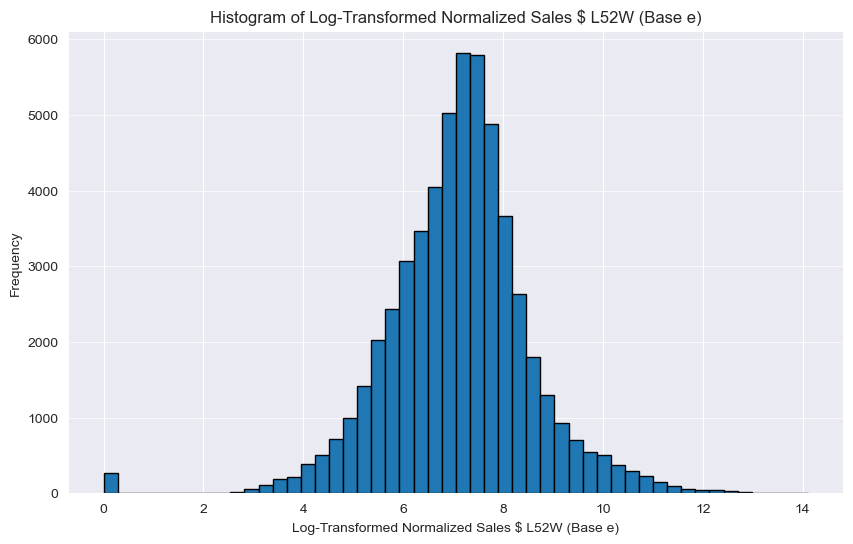

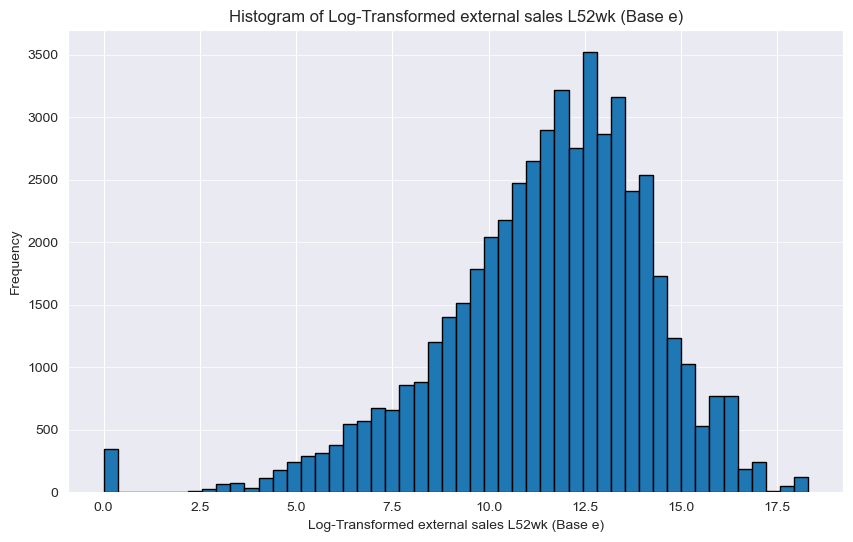

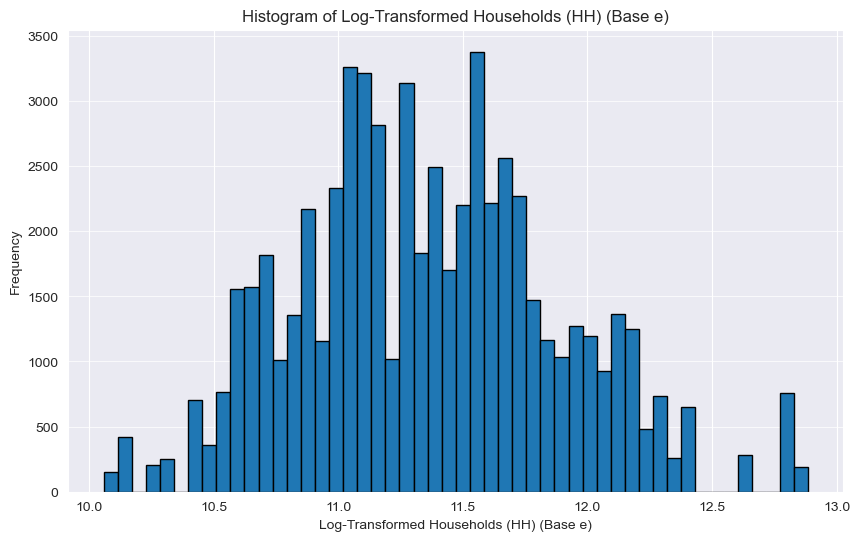

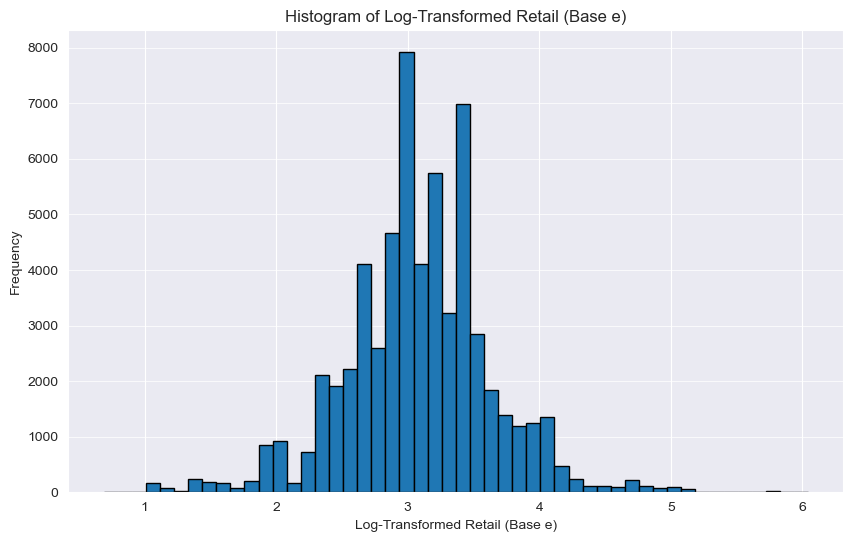

In [ ]:
import numpy as np

columns_log_transform = [
    'Normalized Sales $ L52W',
    'external sales L52wk',
    'Households (HH)',
    'Retail',
]

for col in columns_log_transform:
    final['log_' + col] = np.log1p(final[col])

import matplotlib.pyplot as plt

# Plot histograms for the log-transformed columns
for col in columns_log_transform:
    plt.figure(figsize=(10, 6))
    plt.hist(final['log_' + col], bins=50, edgecolor='black')
    plt.title(f'Histogram of Log-Transformed {col} (Base e)')
    plt.xlabel(f'Log-Transformed {col} (Base e)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()


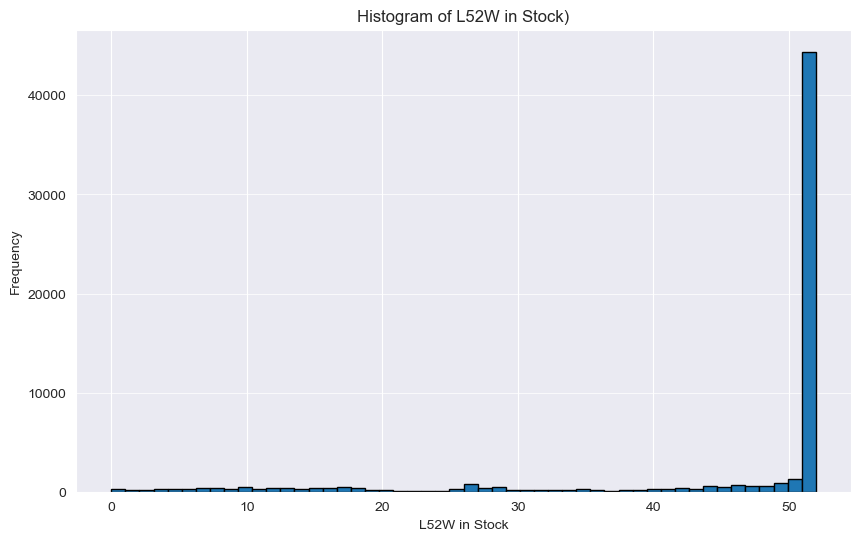

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(final['L52W in Stock'], bins=50, edgecolor='black')
plt.title('Histogram of L52W in Stock)')
plt.xlabel('L52W in Stock')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
# binary variable for L52 in stock
final['L52W_in_stock_binary'] = final['L52W in Stock'].apply(lambda x: 1 if x == 52 else 0)

Preliminary Model (Lasso)

In [ ]:
# Print the column names of the DataFrame
print(final.columns)

Index(['Store Number', 'Store State', 'Item Code', 'Item Name', 'Package Type',
       'Retail', 'L52W in Stock', 'Normalized Sales $ L52W', 'Sales Bucket',
       'external sales L52wk', 'external points of distribution L52wk',
       'Store Name', 'Open Date', 'Price Zone/Market', 'Store Address',
       'Store Size', 'Households (HH)', '% HH Income > $100K',
       'Median HH Income', 'Average Net Worth',
       '% Population w/ Bachelor's Degree +', '% Hispanic', '% Asian',
       '% African American', '% Population Age 50-70', 'US Whiskey',
       'Tequila Under $65', 'Tequila Over $65', 'Scotch Under $75',
       'Scotch Over $75', 'Vodka', 'Cordials', 'Brandy Under $85',
       'Brandy Over $85', 'Cabernet Under $20', 'Cabernet $20-50',
       'Cabernet Over $50', 'Chardonnay Under $20', 'Chardonnay Over $20',
       'Wine - Sparkling', 'Pinot Noir Under $20', 'Pinot Noir Over $20',
       'Sauvignon Blanc', 'French Champagne', 'log_Normalized Sales $ L52W',
       'log_external

In [ ]:
print(final.isna().sum())

Store Number                                0
Store State                                 0
Item Code                                   0
Item Name                                   0
Package Type                                0
Retail                                      0
L52W in Stock                               0
Normalized Sales $ L52W                  6079
Sales Bucket                                0
external sales L52wk                     9416
external points of distribution L52wk    9416
Store Name                                  0
Open Date                                   0
Price Zone/Market                           0
Store Address                               0
Store Size                                  0
Households (HH)                             0
% HH Income > $100K                         0
Median HH Income                            0
Average Net Worth                           0
% Population w/ Bachelor's Degree +         0
% Hispanic                        

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Split the data into 'data' and 'pred' based on 'Sales Bucket'
data = final[final['Sales Bucket'] == 'Sales included']
pred = final[final['Sales Bucket'] == 'Sales excluded for model test']

# Define the features and target for 'data'
X = data[['Package Type', 'Retail', 'L52W_in_stock_binary',
          'log_Households (HH)', 'Vodka', 'Households (HH)', '% HH Income > $100K',
          'Median HH Income', 'Average Net Worth', '% Population w/ Bachelor\'s Degree +',
          '% Hispanic', '% Asian', '% African American', '% Population Age 50-70', 'Store Size']]
y = data['log_Normalized Sales $ L52W']

# Split 'data' into training + validation (90%) and holdout (10%)
X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)

# Split the training + validation set into training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Define preprocessing for numerical and categorical features
numerical_features = ['Retail',
                      'log_Households (HH)', 'Households (HH)', '% HH Income > $100K',
                      'Median HH Income', 'Average Net Worth', '% Population w/ Bachelor\'s Degree +',
                      '% Hispanic', '% Asian', '% African American', '% Population Age 50-70']
categorical_features = ['Package Type', 'Vodka', 'Store Size', 'L52W_in_stock_binary']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Lasso regression pipeline
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', LassoCV(cv=5, max_iter=10000))
])

# Fit the Lasso regression model on training data
lasso_pipeline.fit(X_train, y_train)

# Print model performance on training and validation sets
print("Lasso Regression Model Performance:")
print("Training Score:", lasso_pipeline.score(X_train, y_train))
print("Validation Score:", lasso_pipeline.score(X_val, y_val))

Lasso Regression Model Performance:
Training Score: 0.1915346439894935
Validation Score: 0.1892141844525551


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def print_evaluation_metrics(y_true, y_pred, set_name="Evaluation"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{set_name} RMSE: {rmse:.4f}")
    print(f"{set_name} MAE: {mae:.4f}")

y_val_pred = lasso_pipeline.predict(X_val)

print_evaluation_metrics(y_val, y_val_pred, set_name="Validation")

Validation RMSE: 1.2695
Validation MAE: 0.9293
